In [ ]:
# 필요한 모듈 임포트

import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

In [ ]:
# MNIST 손글씨 이미지 데이터 로드

mnist = keras.datasets.mnist
(X_train_all, y_train_all),(X_test, y_test) = mnist.load_data()

print(X_train_all.shape, y_train_all.shape)
print(X_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [ ]:
# 첫번째 데이터 확인 및 출력

for row in range(28):
  for col in range(28):
    print('{:4d}'.format(X_train_all[0][row][col]), end="")
  print()

   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255 247 127   0   0   0   0
   0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0
   0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82  82  56  39   0   0   0   0   0
   0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 182 247 241   0   0   0   0   0   0

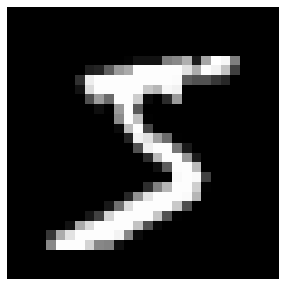

In [ ]:
# 첫번째 데이터 시각화

def plot_img(data,idx):
  plt.figure(figsize=(5,5))
  plt.imshow(data[idx], cmap='gray')
  plt.axis('off');

plot_img(X_train_all,0)

In [ ]:
# 첫번째 라벨 확인
y_train_all[0]

5

In [ ]:
# CNN 채널 정보 추가(차원 늘리기): CNN(샘플 수, 행 수, 열 수, 채널 수)
# MNIST data는 흑백 -> mono channel

X_train_all = X_train_all[...,tf.newaxis]
X_test = X_test[...,tf.newaxis]

print(X_train_all.shape, X_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [ ]:
# CNN 모델 구성

from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation
from keras.models import Sequential

model = Sequential([Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1), name='conv'),
                    MaxPooling2D((2,2), name='pool'), # Max Pooling 적용, stride는 pooling과 똑같이 적용됨(2)
                    Flatten(), # 여기부터 classifier 출력층
                    Dense(64), BatchNormalization(), Activation('relu'), 
                    Dropout(0.2),
                    Dense(32),BatchNormalization(), Activation('relu'),
                    Dropout(0.2),
                    Dense(10, activation='softmax')]) # MNIST는 class 10개, 다중 분류니까 softmax

In [ ]:
# model compile

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# 모델 구조 확인

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv (Conv2D)               (None, 26, 26, 32)        320       
                                                                 
 pool (MaxPooling2D)         (None, 13, 13, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 5408)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                346176    
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64)                0         
                                                      

In [ ]:
# 학습 데이터, 검증 데이터 분리

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.3, random_state=42)

In [ ]:
# 체크포인트

check = keras.callbacks.ModelCheckpoint(filepath='tmp_checkpoint.ckpt', save_weights_only=True, save_best_only=True, monitor = 'val_loss', verbose=1)

In [ ]:
# 학습률 조정

def scheduler(epoch, lr):
  tf.print(f'learning_rate: {lr:.5f}')
  lr=lr*0.3
  if epoch <3:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

In [ ]:
# 스케줄러 생성

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
# 모델 학습

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[check, lr_scheduler])

learning_rate: 0.00100
Epoch 1/100
1311/1313 [============================>.] - ETA: 0s - loss: 0.4877 - accuracy: 0.8941
Epoch 00001: val_loss improved from inf to 0.11249, saving model to tmp_checkpoint.ckpt
1313/1313 [==============================] - 30s 22ms/step - loss: 0.4875 - accuracy: 0.8941 - val_loss: 0.1125 - val_accuracy: 0.9744 - lr: 3.0000e-04
learning_rate: 0.00030
Epoch 2/100
1311/1313 [============================>.] - ETA: 0s - loss: 0.1791 - accuracy: 0.9606
Epoch 00002: val_loss improved from 0.11249 to 0.07815, saving model to tmp_checkpoint.ckpt
1313/1313 [==============================] - 30s 23ms/step - loss: 0.1790 - accuracy: 0.9607 - val_loss: 0.0782 - val_accuracy: 0.9800 - lr: 9.0000e-05
learning_rate: 0.00009
Epoch 3/100
1312/1313 [============================>.] - ETA: 0s - loss: 0.1470 - accuracy: 0.9663
Epoch 00003: val_loss improved from 0.07815 to 0.07069, saving model to tmp_checkpoint.ckpt
1313/1313 [==============================] - 30s 23ms/step

In [ ]:
# 체크포인트에 저장된 가중치 확인

model.load_weights('tmp_checkpoint.ckpt')

In [ ]:
model.evaluate(X_val, y_val)

563/563 [==============================] - 6s 10ms/step - loss: 0.0675 - accuracy: 0.9829


[0.06752501428127289, 0.9829444289207458]

In [ ]:
# 훈련한 모델 저장

model.save('cnn_model1.h5')

In [ ]:
# 저장한 모델 불러와 확인

cnn1 = keras.models.load_model('cnn_model1.h5')
cnn1.evaluate(X_val, y_val)

563/563 [==============================] - 5s 9ms/step - loss: 0.0675 - accuracy: 0.9829


[0.06752501428127289, 0.9829444289207458]

In [ ]:
# 테스트 데이터 예측

y_pred = cnn1.predict(X_test)
y_pred

array([[1.11226764e-05, 2.12588038e-05, 1.33824915e-05, ...,
        9.98133481e-01, 1.64041179e-04, 7.46283098e-04],
       [4.70207119e-03, 7.68062565e-03, 9.73256409e-01, ...,
        8.76692007e-04, 4.88812395e-04, 1.18957018e-03],
       [5.59337204e-04, 9.95358407e-01, 4.75982379e-04, ...,
        1.56878680e-03, 2.74760678e-04, 1.86898280e-04],
       ...,
       [4.20577744e-05, 5.64826885e-04, 1.67156486e-05, ...,
        9.45282110e-04, 8.39308123e-05, 4.21674777e-04],
       [1.20167497e-04, 1.34927672e-04, 3.50906717e-04, ...,
        1.09405199e-04, 7.93976185e-04, 5.78877109e-04],
       [7.76410277e-04, 1.10324268e-04, 1.53614196e-03, ...,
        3.21445026e-04, 1.28545589e-03, 2.88711271e-05]], dtype=float32)

In [ ]:
# target label 생성

y_pred_class = np.argmax(y_pred, axis=-1)
y_pred_class

array([7, 2, 1, ..., 4, 5, 6])

In [ ]:
# 제출 파일 생성

sub = pd.read_csv('/content/submission.csv')
sub['label'] = y_pred_class
sub.to_csv('/content/submission.csv', index=False)

### 제출 점수: Accuracy 0.9835